In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from astropy import units as u
from astropy.table import join, Table

from IPython.display import display
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

from catalogues import Catalogue

import swasputils

In [3]:
superwasp_sources = swasputils.UnifiedSubjects().get_workflow(swasputils.MAIN_WORKFLOW)
superwasp_sources = superwasp_sources.real
superwasp_sources = superwasp_sources.remove_class(superwasp_sources.UNKNOWN)
superwasp_sources.add_classification_labels()
superwasp_sources.df['SuperWASP Coords'] = superwasp_sources.df['SWASP ID'].replace(r'^1SWASP', '', regex=True)

In [4]:
harmonic_groups = pandas.read_pickle(os.path.join(swasputils.CACHE_LOCATION, 'harmonic_groups.pickle'))

In [5]:
superwasp_periods = Table.from_pandas(superwasp_sources.df.merge(harmonic_groups)[[
    'Period', 'SuperWASP Coords', 'Harmonic Group', 'Classification Label'
]])

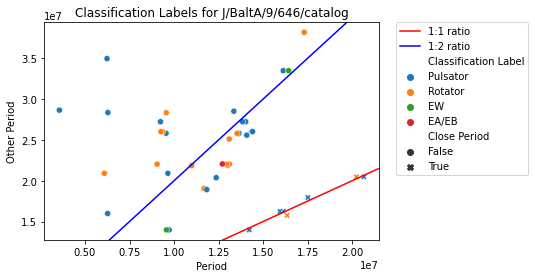

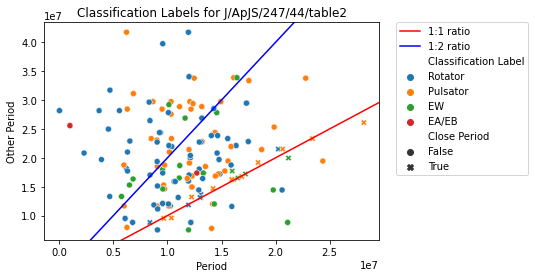

In [18]:
catalogue_matches = {}
for catalogue in Catalogue.all():
    matched_table = catalogue.matched_table
    matched_table['Other Period'] = matched_table[catalogue.per_col].to(u.second)
    matched_periods_all = join(matched_table[['Other Period', 'SuperWASP Coords']], superwasp_periods, join_type='inner').to_pandas()
    matched_periods_all = matched_periods_all[matched_periods_all['Other Period'] < 5e7]
    matched_periods_all['Close Period'] = numpy.isclose(
        matched_periods_all['Period'],
        matched_periods_all['Other Period'],
        atol=0,
        rtol=1e-1, # To do: Figure out a justifiable value for this!
    )
    
    matched_periods = matched_periods_all.copy(deep=False)
    
    for group_name, group_periods in matched_periods_all.groupby('SuperWASP Coords'):
        # Keep the closest period
        matched_periods = matched_periods.append(
            group_periods.loc[
                numpy.abs(
                    group_periods['Period'] - group_periods['Other Period']
                ).idxmin()
            ]
        )

    matched_periods['log(Period)'] = numpy.log10(matched_periods['Period'])
    matched_periods['log(Other Period)'] = numpy.log10(matched_periods['Other Period'])
    matched_periods['Ratio'] = matched_periods['Other Period'] / matched_periods['Period']
    matched_periods['log(Ratio)'] = numpy.log10(matched_periods['Ratio'])
    
    catalogue_matches[catalogue.name] = {
        'closest': matched_periods,
        'all': matched_periods_all,
    }
    
    #seaborn.scatterplot(
    #    data=matched_periods_all,
    #    x='Period',
    #    y='Other Period',
    #    hue='Close Period',
    #).set(title=f'Matching SuperWASP Periods for {catalogue}')
    #plt.show()
    
    #seaborn.scatterplot(
    #    data=matched_periods,
    #    x='Period',
    #    y='Other Period',
    #    hue='Close Period',
    #).set(title=f'Closest SuperWASP Periods for {catalogue}')
    #plt.show()

    seaborn.scatterplot(
        data=matched_periods,
        x='Period',
        y='Other Period',
        hue='Classification Label',
        style='Close Period',
    ).set(title=f'Classification Labels for {catalogue}')
    
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    x = numpy.linspace(x_min, x_max, 100)
    y = 2*x
    plt.plot(x, x, '-r', label='1:1 ratio')
    plt.plot(x, y, '-b', label='1:2 ratio')
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    #seaborn.displot(data=matched_periods, x="log(Ratio)").set(title=f'SuperWASP Period Ratios for {catalogue}')
    #plt.show()
    
    #seaborn.countplot(data=matched_periods, x='Close Period').set(title=f'Period Closeness {catalogue}')
    #plt.show()

In [7]:
for catalogue, matches in catalogue_matches.items():
    print(f'Summary for {catalogue}:')
    display(matches['closest'].groupby(['Classification Label', 'Close Period']).size())
    display(matches['closest'].groupby('Close Period').size())

Summary for J/BaltA/9/646/catalog:


Classification Label  Close Period
EA/EB                 False            2
EW                    False            4
Pulsator              False           37
                      True            10
Rotator               False           27
                      True             4
dtype: int64

Close Period
False    155
True      20
dtype: int64

Summary for J/ApJS/247/44/table2:


Classification Label  Close Period
EA/EB                 False             4
EW                    False            28
                      True             10
Pulsator              False           124
                      True             24
Rotator               False           122
                      True             12
dtype: int64

Close Period
False    591
True      76
dtype: int64